In [126]:
using Revise

In [127]:
using Distributed
procs_to_use = 10

if nprocs() <= procs_to_use
    addprocs(procs_to_use-nprocs())
end

@everywhere using
    QuantumStates,
    OpticalBlochEquations,
    DifferentialEquations,
    UnitsToValue,
    LinearAlgebra,
    Printf,
    Plots,
    Random,
    StatsBase,
    Distributions,
    StructArrays,
    StaticArrays,
    StructArrays,
    LoopVectorization,
    Parameters,
    MutableNamedTuples,
    ProgressMeter

@everywhere @consts begin
    λ = 606e-9
    Γ = 2π * 8.3e6
    m = @with_unit 59 "u"
    k = 2π / λ
    _μB = (μB / h) * 1e-4
    kB = 1.380649e-23
end
;

### Calculate transition dipole moments

In [128]:
@everywhere begin
    include("define_CaF_states.jl")
    X_states, A_states = define_CaF_states()
    states = [X_states; A_states[1:4]]
    d = tdms_between_states(states, states)
end
;

### Define Zeeman and ODT Hamiltonians

In [129]:
@everywhere include("define_Zeeman_Hamiltonian.jl")
;

### Run simulation

In [130]:
@everywhere function update_H_and_∇H(H, p, r, t)

    # define a ramping magnetic field
    Zeeman_Hz = p.extra_data.Zeeman_Hz
    Zeeman_Hx = p.extra_data.Zeeman_Hx
    Zeeman_Hy = p.extra_data.Zeeman_Hy

    # set ramp factor
    τ_bfield = p.sim_params.B_ramp_time
    scalar = t/τ_bfield
    scalar = min(scalar, 1.0)
    
    gradient_x = +scalar * p.sim_params.B_gradient * 1e2 / k / 2
    gradient_y = +scalar * p.sim_params.B_gradient * 1e2 / k / 2
    gradient_z = -scalar * p.sim_params.B_gradient * 1e2 / k
    
    Bx = gradient_x * r[1] + p.sim_params.B_offset[1]
    By = gradient_y * r[2] + p.sim_params.B_offset[2]
    Bz = gradient_z * r[3] + p.sim_params.B_offset[3]
    
    @turbo for i in eachindex(H)
        H.re[i] = Bz * Zeeman_Hz.re[i] + Bx * Zeeman_Hx.re[i] + By * Zeeman_Hy.re[i]
        H.im[i] = Bz * Zeeman_Hz.im[i] + Bx * Zeeman_Hx.im[i] + By * Zeeman_Hy.im[i]
    end

    ∇H = SVector{3, Float64}(0,0,0)
    
    # H_ODT = p.extra_data.H_ODT
    
    # ODT_x = p.sim_params.ODT_position[1] / (1 / p.k)
    # ODT_y = 0.0
    # ODT_z = p.sim_params.ODT_position[2] / (1 / p.k)
    
    # ODT_size = p.sim_params.ODT_size ./ (1 / p.k)
    
    # x, y, z = r
    # r2 = x^2 + y^2 + z^2
    
    # w0 = ODT_size[1]
    # zR = π*w0^2 / λ
    
    # # define some factors
    # a = 1 + (z/zR)^2
    # wz = w0 * sqrt(a)
    
    # b = exp(-2r2/wz^2)
    
    # scalar_ODT = (w0/wz)^2 * b
    
    # @turbo for i in eachindex(H)
    #     H.re[i] += H_ODT[i] * scalar_ODT
    # end
    
    # ∇H = SVector{3, Float64}(
    #     -4x * b / (a * wz^2), 
    #     -4y * b / (a * wz^2), 
    #     (-4z * b / wz^2) * (1 / a - r2 / zR^2) - 2z * b / (a^2 * zR^2)
    #     )
    
    return ∇H
end

In [1219]:
@everywhere begin

    Isat = π*h*c*Γ/(3λ^3)
    
    # # CaF blue MOT
    # P = 30e-3 # total power in each of X,Y,Z = 30 mW
    # I = 2P / (π * 10e-3^2) # 10 mm 1/e^2 diameter beams
    # s = I / Isat
    
    # s1 = s / 3
    # s2 = 0.
    # s3 = 0.
    # s4 = s / 3
    # s5 = s / 3
    
    # detuning = +21
    # δ1 = -1.0 # 20.0 from F=1-
    # δ2 = +0.0
    # δ3 = +0.0
    # δ4 = -1.7 # 19.3 from F=2
    # δ5 = +0.0 # 21.0 from F=2
    
    # # CaF Λ-cooling
    # P = 10e-3 # total power in each of X,Y,Z = 30 mW
    # I = 2P / (π * 10e-3^2) # 10 mm 1/e^2 diameter beams
    # s = I / Isat
    
    # s1 = 1s/5
    # s2 = 0s
    # s3 = 0s
    # s4 = 4s/5
    # s5 = 0s
    
    # detuning = +20.0
    # δ1 = +0.0
    # δ2 = +0.0
    # δ3 = +0.0
    # δ4 = +0.0
    # δ5 = +0.0
    
    # # CaF SF-cooling
    # Isat = π*h*c*Γ/(3λ^3) / 10
    # I = 30 # mW/cm^2, for each beam
    # s = I / Isat
    
    # s1 = s
    # s2 = s
    # s3 = 0s
    # s4 = 0s
    # s5 = 0s
    
    # detuning = +40.0
    # δ1 = +0.0
    # δ2 = +1.5
    # δ3 = +0.0
    # δ4 = +0.0
    # δ5 = +0.0
    
#     # CaF SF blue MOT
#     P = 10e-3 # total power in each of X,Y,Z beams
#     I = 2P / (π * 10e-3^2) # 10 mm 1/e^2 diameter beams
#     s = I / Isat
    
#     s1 = 20s
#     s2 = 20s
#     s3 = 0s
#     s4 = 10s
#     s5 = 10s
    
#     detuning = -50.0
#     δ1 = -0.60
#     δ2 = -1.00
#     δ3 = +0.0
#     δ4 = -0.00
#     δ5 = -0.00
    
    # CaF SF blue MOT
    P = 10e-3 # total power in each of X,Y,Z beams
    I = 2P / (π * 10e-3^2) # 10 mm 1/e^2 diameter beams
    s = I / Isat
    
    s1 = 5s
    s2 = 5s
    s3 = 0s
    s4 = 1s
    s5 = 0s
    
    detuning = +15.0
    δ1 = -0.60
    δ2 = -1.00
    δ3 = +0.00
    δ4 = -1.00
    δ5 = -0.00
    
end
;

In [1220]:
@everywhere sim_params = MutableNamedTuple(
    
    pol_imbalance = 0.,
    s_imbalance = (0., 0., 0.),
    retro_loss = 0.,
    off_center = (0, 0, 0, 0, 0, 0) .* 1e-3,
    pointing_error = (0, 0, 0, 0, 0, 0),

    B_gradient = +100.,
    B_ramp_time = 1e-9,
    B_offset = (0., 0., 0.),
    
    s_ramp_time = 1e-9,
    s_ramp_to = 1.0,

    s1 = s1,
    s2 = s2,
    s3 = s3,
    s4 = s4,
    s5 = s5,
    Δ1 = detuning + δ1,
    Δ2 = detuning + δ2,
    Δ3 = detuning + δ3,
    Δ4 = detuning + δ4,
    Δ5 = detuning + δ5,
    pol1_x = [1,0,0],
    pol2_x = [0,0,1],
    pol3_x = [0,0,1],
    pol4_x = [0,0,1],
    pol5_x = [1,0,0],

    ODT_intensity = 4*4*2*13 / (π * (30e-6)^2),
    ODT_size = (30e-6, 1000e-6, 30e-6),
    ODT_position = [0., 0.],
    ODT_pol = [0,1,0]

)
;

In [1221]:
# @everywhere begin
#     include("define_ODT_Hamiltonian.jl")
#     H_ODT = get_H_ODT(states, X_states, A_states, sim_params.ODT_intensity, sim_params.ODT_pol)
# end
# ;

In [1222]:
@everywhere extra_data = MutableNamedTuple(
    Zeeman_Hx = Zeeman_x_mat,
    Zeeman_Hy = Zeeman_y_mat,
    Zeeman_Hz = Zeeman_z_mat,
    H_ODT = H_ODT
)
;

### Define lasers

In [1223]:
@everywhere begin
    include("define_lasers.jl")
    lasers = define_lasers(
        states,
        sim_params.s1,
        sim_params.s2,
        sim_params.s3,
        sim_params.s4,
        sim_params.s5,
        sim_params.Δ1,
        sim_params.Δ2,
        sim_params.Δ3,
        sim_params.Δ4,
        sim_params.Δ5,
        sim_params.pol1_x,
        sim_params.pol2_x,
        sim_params.pol3_x,
        sim_params.pol4_x,
        sim_params.pol5_x,
        sim_params.s_ramp_time,
        sim_params.s_ramp_to,
        sim_params.pol_imbalance,
        sim_params.s_imbalance,
        sim_params.retro_loss,
        sim_params.off_center,
        sim_params.pointing_error
    )
end
;

In [1224]:
# @everywhere diffusion_constant = [0.0, 0.0, 0.0]
@everywhere diffusion_constant = [0.012, 0.012, 0.012]
;

In [1225]:
@everywhere begin
    t_start = 0.0
    t_end   = 5e-3
    t_span  = (t_start, t_end) ./ (1/Γ)

    using Logging: global_logger
    using TerminalLoggers: TerminalLogger
    global_logger(TerminalLogger())

    # define particle and initial position
    particle = Particle()
    particle.r = [0., 0., 0.1e-3] ./ (1/k)

    ψ₀ = zeros(ComplexF64, length(states))
    ψ₀[1] = 1.0

    p = schrodinger_stochastic_constant_diffusion(particle, states, lasers, d, ψ₀, m/(ħ*k^2/Γ), 4, diffusion_constant; sim_params=sim_params, extra_data=extra_data, λ=λ, Γ=Γ, update_H_and_∇H=update_H_and_∇H)
    prob = ODEProblem(ψ_stochastic_potential!, p.ψ, t_span, p)
    cb = ContinuousCallback(condition_simple, SE_collapse_pol_constant_diffusion!, nothing, save_positions=(false,false))
end
@time sol = DifferentialEquations.solve(prob; alg=DP5(), reltol=1e-3, callback=cb, saveat=10, maxiters=80000000, progress=true, progress_steps=100000)
;

ODE   0%|█                                              |  ETA: N/A
ODE   6%|███                                            |  ETA: 0:00:24
ODE  12%|██████                                         |  ETA: 0:00:22
ODE  18%|█████████                                      |  ETA: 0:00:21
ODE  23%|███████████                                    |  ETA: 0:00:19
ODE  29%|██████████████                                 |  ETA: 0:00:18
ODE  35%|█████████████████                              |  ETA: 0:00:16
ODE  41%|████████████████████                           |  ETA: 0:00:15
ODE  47%|██████████████████████                         |  ETA: 0:00:13
ODE  53%|█████████████████████████                      |  ETA: 0:00:12
ODE  59%|████████████████████████████                   |  ETA: 0:00:10
ODE  64%|███████████████████████████████                |  ETA: 0:00:09
ODE  70%|██████████████████████████████████             |  ETA: 0:00:07
ODE  77%|████████████████████████████████████           |  ETA: 0:00

 28.819804 seconds (4.97 M allocations: 339.606 MiB, 0.40% gc time, 14.20% compilation time)


ODE 100%|███████████████████████████████████████████████| Time: 0:00:24


In [1229]:
x(u) = real(u[16+4+1]) * (1/k)
y(u) = real(u[16+4+2]) * (1/k)
z(u) = real(u[16+4+3]) * (1/k)
vx(u) = real(u[16+4+4]) * (Γ/k)
vy(u) = real(u[16+4+5]) * (Γ/k)
vz(u) = real(u[16+4+6]) * (Γ/k)
;

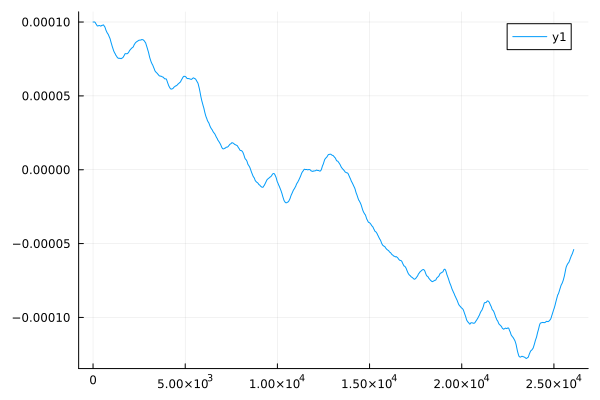

In [1230]:
z.(sol.u) |> plot

In [1231]:
sol.prob.p.n_scatters / 5e-3

880600.0

## Simulate multiple particles

In [1232]:
@everywhere using Distributions, Plots

In [1233]:
@everywhere begin
    const x_dist = Normal(0,60e-6)
    const y_dist = Normal(0,60e-6)
    const z_dist = Normal(0,60e-6)
end

@everywhere begin
    const Temp = 100e-6
    const vx_dist = Normal(0,sqrt(kB*Temp/(2m)))
    const vy_dist = Normal(0,sqrt(kB*Temp/(2m)))
    const vz_dist = Normal(0,sqrt(kB*Temp/(2m)))
end

@everywhere function sample_position()
    r = (rand(x_dist), rand(y_dist), rand(z_dist))
end

@everywhere function sample_velocity()
    v = (rand(vx_dist), rand(vy_dist), rand(vz_dist))
end
;

In [1234]:
@everywhere function prob_func(prob, i, repeat)
    
    t_start = 0.0
    t_end   = 5e-3
    t_span  = (t_start, t_end) ./ (1/Γ)
    
    extra_data = prob.p.extra_data
    sim_params = prob.p.sim_params

    diffusion_constant = prob.p.diffusion_constant
    
    # set initial particle parameters
    particle = Particle()
    r0 = sample_position()
    particle.r = r0 ./ (1/k)
    v0 = sample_velocity()
    particle.v = v0 ./ (Γ/k)

    ψ₀ = zeros(ComplexF64, length(states))
    ψ₀[1] = 1.0
    
    # define lasers
    lasers = define_lasers(
        states,
        sim_params.s1,
        sim_params.s2,
        sim_params.s3,
        sim_params.s4,
        sim_params.s5,
        sim_params.Δ1,
        sim_params.Δ2,
        sim_params.Δ3,
        sim_params.Δ4,
        sim_params.Δ5,
        sim_params.pol1_x,
        sim_params.pol2_x,
        sim_params.pol3_x,
        sim_params.pol4_x,
        sim_params.pol5_x,
        sim_params.s_ramp_time,
        sim_params.s_ramp_to,
        sim_params.pol_imbalance,
        sim_params.s_imbalance,
        sim_params.retro_loss,
        sim_params.off_center,
        sim_params.pointing_error
    )

    d = prob.p.d
    n_excited = prob.p.n_excited

    p = schrodinger_stochastic_constant_diffusion(particle, states, lasers, d, ψ₀, m/(ħ*k^2/Γ), n_excited, diffusion_constant; sim_params=sim_params, extra_data=extra_data, λ=λ, Γ=Γ, update_H_and_∇H=update_H_and_∇H)
    cb = ContinuousCallback(condition_simple, SE_collapse_pol_constant_diffusion!, nothing, save_positions=(false,false))
    prob = ODEProblem(ψ_stochastic_potential!, p.ψ, t_span, p; callback=cb, reltol=1e-3, saveat=1000, maxiters=80000000)
    
    return prob
end
;

In [1235]:
ensemble_prob = EnsembleProblem(prob; prob_func=prob_func)
@time ensemble_sol = solve(ensemble_prob, DP5(), EnsembleDistributed(); trajectories=40)
;

139.666351 seconds (2.16 M allocations: 118.435 MiB, 0.03% gc time, 1.89% compilation time)


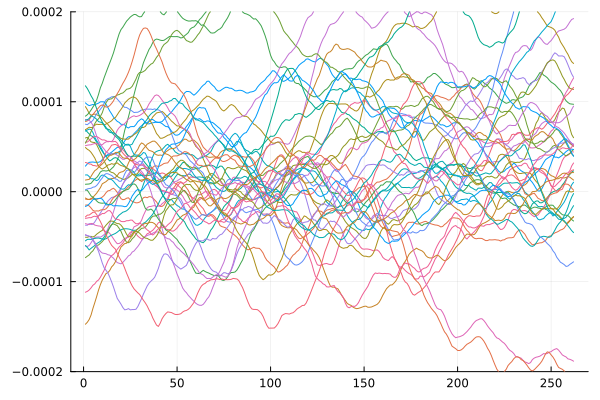

In [1237]:
plot()
for sol ∈ ensemble_sol
    plot!(z.(sol.u))
end
plot!(
    legend=nothing,
    ylim=(-0.2e-3,0.2e-3)
    # ylim=(-0.05e-3,0.05e-3)
)

## Fitted size

In [1238]:
using StatsBase

In [1239]:
survived(x,y,z) = sqrt(x^2+y^2+z^2) <= 0.5e-3

function size(ensemble_sol, idx)
    xs = Float64[]
    ys = Float64[]
    zs = Float64[]
    for i ∈ eachindex(ensemble_sol)
        sol = ensemble_sol[i] 
        _x = x(sol.u[idx])
        _y = y(sol.u[idx])
        _z = z(sol.u[idx])
        if survived(_x,_y,_z)
            push!(xs, _x)
            push!(ys, _y)
            push!(zs, _z)
        end
    end
    return (std(xs) * std(ys) * std(zs))^(1/3)
end
;

In [1240]:
using LsqFit

function Gaussian(x, p)
    σ, x0, A = p
   return A * exp.(-(x.-x0).^2/(2*σ^2))
end

function cloud_size_fitted(xs)

    hist_data = fit(Histogram, xs, -1e-3:1e-5:1e-3)
    hist_data.isdensity = true
    v = collect(hist_data.edges[1])
    dv = v[2]-v[1]
    v = v[1:end-1] .+ dv/2
    fv = hist_data.weights ./ (sum(hist_data.weights) * dv)

    # histogram(hist_data)
    
    v_fit = curve_fit(Gaussian, v, fv, [60e-6, 0., 5000])
    σ, x0, A = v_fit.param
    
    # histogram!(xs, bins=hist_data.edges, xlim=(-0.3, 0.3), alpha=0.5, normalize=true)
    return σ
end
;

In [1241]:
xs = [x.(sol.u) for sol ∈ ensemble_sol]
ys = [y.(sol.u) for sol ∈ ensemble_sol]
zs = [z.(sol.u) for sol ∈ ensemble_sol]

survived_idxs = [survived(xs[i][end], ys[i][end], zs[i][end]) for i ∈ eachindex(xs)]

survived_xs = xs[survived_idxs]
survived_ys = ys[survived_idxs]
survived_zs = zs[survived_idxs]
;

3-element Vector{Float64}:
    4.359363876719733e-5
    3.1312726136690484e-5
 6928.515224149416

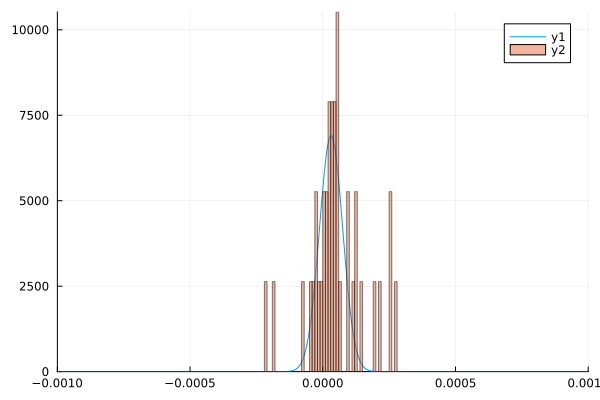

In [1242]:
zs_end = [z[end] for z ∈ survived_zs]

hist_data = fit(Histogram, zs_end, -1e-3:1e-5:1e-3)
hist_data.isdensity = true
v = collect(hist_data.edges[1])
dv = v[2]-v[1]
v = v[1:end-1] .+ dv/2
fv = hist_data.weights ./ (sum(hist_data.weights) * dv)

v_fit = curve_fit(Gaussian, v, fv, [60e-6, 0., 5000])
σ, x0, A = v_fit.param

display(v_fit.param)
plot(v, Gaussian(v, v_fit.param))
histogram!(zs_end, bins=hist_data.edges, xlim=(-1e-3, +1e-3), alpha=0.5, normalize=true)

In [1243]:
cloud_sizes_x_fitted = [cloud_size_fitted([traj[i] for traj ∈ survived_xs]) for i ∈ eachindex(survived_xs[1])]
cloud_sizes_y_fitted = [cloud_size_fitted([traj[i] for traj ∈ survived_ys]) for i ∈ eachindex(survived_ys[1])]
cloud_sizes_z_fitted = [cloud_size_fitted([traj[i] for traj ∈ survived_zs]) for i ∈ eachindex(survived_zs[1])]
cloud_sizes_fitted = (abs.(cloud_sizes_x_fitted) .* abs.(cloud_sizes_y_fitted) .* abs.(cloud_sizes_z_fitted)).^(1/3)
;

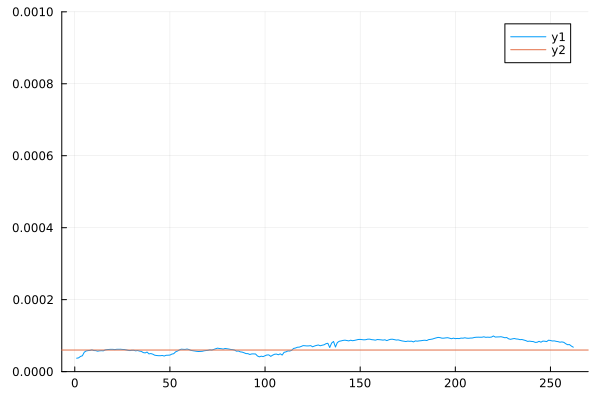

In [1244]:
plot(cloud_sizes_fitted)
plot!(ylim=(0,1000e-6))
hline!([60e-6])

In [1245]:
cloud_sizes_fitted

262-element Vector{Float64}:
 3.7246283827757584e-5
 3.8179045677005115e-5
 4.217932562091794e-5
 4.404750199991444e-5
 5.398297509988125e-5
 5.746461932421051e-5
 5.848496295052654e-5
 5.88709282968933e-5
 6.0364403884282545e-5
 5.859006254646316e-5
 5.8386037204722836e-5
 5.681283098383229e-5
 5.776757487435706e-5
 ⋮
 8.506505142200656e-5
 8.544984412504249e-5
 8.415755701747865e-5
 8.329944846121534e-5
 8.174267624222051e-5
 8.257088593127686e-5
 8.144592513764763e-5
 7.76456816003179e-5
 7.475680971241891e-5
 7.513623090815565e-5
 7.094791707615655e-5
 6.79102725710045e-5

## Fitted temperature

In [1034]:
using LsqFit

0.00014579836394082115

2-element Vector{Float64}:
 1.0900717536336064
 0.00016435173410697334

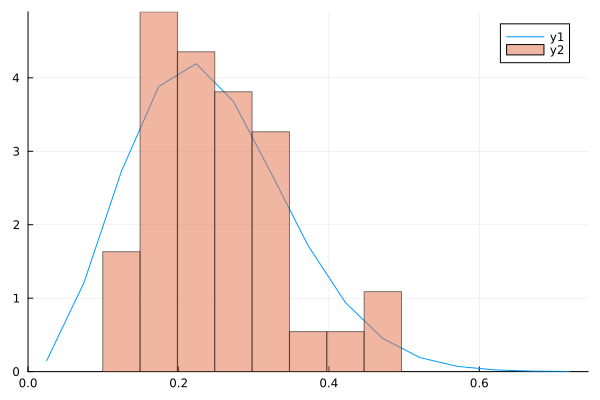

In [1035]:
survived_sols = [sol for (i,sol) ∈ enumerate(ensemble_sol) if survived_idxs[i]]

i = length(ensemble_sol[1].t) - 10
vs = [sqrt(vx(sol.u[i])^2 + vy(sol.u[i])^2 + vz(sol.u[i])^2) for sol ∈ survived_sols]
m * mean(vs)^2 / 3kB |> display

function maxwell_boltzmann(v, p)
    A, temp = p
    return A * ((m/(2π*kB*temp))^(3/2) * 4π) .* v .^2 .* exp.(v .^2 .* (-m / (2*kB*temp)))
end

vs_tofit = vs#[vs .< 0.5]

hist_data = fit(Histogram, vs_tofit, 0.0:mean(vs_tofit)/5:mean(vs_tofit)*3)
hist_data.isdensity = true
v = collect(hist_data.edges[1])
dv = v[2]-v[1]
v = v[1:end-1] .+ dv/2
fv = hist_data.weights ./ (sum(hist_data.weights) * dv)

histogram(hist_data)

v_fit = curve_fit(maxwell_boltzmann, v, fv, [5, 100e-6])
A, temp = v_fit.param

display(v_fit.param)
plot(v, maxwell_boltzmann(v, v_fit.param))
histogram!(vs_tofit, bins=hist_data.edges, xlim=(0.0, mean(vs)*3), alpha=0.5, normalize=true)

## Calculate diffusion

In [1085]:
@everywhere begin
    using ProgressMeter, StatsBase, Plots, Distributions
end

In [1090]:
@everywhere begin
    const x_dist = Normal(0,60e-6)
    const y_dist = Normal(0,60e-6)
    const z_dist = Normal(0,60e-6)
end

@everywhere begin
    const Temp = 60e-6
    const vx_dist = Normal(0,sqrt(kB*Temp/(3m)))
    const vy_dist = Normal(0,sqrt(kB*Temp/(3m)))
    const vz_dist = Normal(0,sqrt(kB*Temp/(3m)))
end

@everywhere function sample_position()
    r = (rand(x_dist), rand(y_dist), rand(z_dist))
end

@everywhere function sample_velocity()
    v = (rand(vx_dist), rand(vy_dist), rand(vz_dist))
end
;

In [1091]:
@everywhere function compute_diffusion_averaged_real(prob, n_avgs, τ_total)
    
    # data arrays
    Cs = zeros(ComplexF64, length(τ_times))
    fτ_fts = zeros(ComplexF64, length(τ_times))

    χm  = zeros(ComplexF64, prob.p.n_states)
    χp  = zeros(ComplexF64, prob.p.n_states)
    χm′ = zeros(ComplexF64, prob.p.n_states)
    χm′ = zeros(ComplexF64, prob.p.n_states)
    
    ψ₀ = zeros(ComplexF64, prob.p.n_states)
    ψ₀[13] = 1.0
        
    ϕs = zeros(6)
    
    @showprogress for i ∈ 1:n_avgs
        
        # set times to simulate
        t_start = 0.0
        t_end   = 1e-6 + 3e-6 * rand()
        t_span  = (t_start, t_end)

        τ_start = t_end
        τ_end   = τ_start + τ_total
        τ_span  = (τ_start, τ_end)

        n_times = 5000
        τ_times = range(τ_span[1], τ_span[2], n_times)

        # round all times
        t_span  = round.(t_span ./ (1/Γ), digits=9)
        τ_span  = round.(τ_span ./ (1/Γ), digits=9)
        τ_times = round.(τ_times[1:end-1] ./ (1/Γ), digits=9)
        
        r0 = sample_position()
        v0 = sample_velocity()
        prob.p.r  = r0 ./ (1/k)
        prob.p.r0 = r0 ./ (1/k)
        prob.p.v  = v0 ./ (Γ/k)
        
        for i ∈ eachindex(ϕs)
            ϕs[i] = 2π*rand()
        end
        
        prob.p.fields.ϕ[1:6]   = ϕs
        prob.p.fields.ϕ[7:12]  = ϕs
        prob.p.fields.ϕ[13:18] = ϕs
        prob.p.fields.ϕ[19:24] = ϕs
        
        prob.u0 .= 0.0
        prob.u0[1:16] = ψ₀
        prob.p.time_to_decay = rand(prob.p.decay_dist) # reset the time to decay
        sol_ϕ = DifferentialEquations.solve(prob, tspan=t_span)
        ut = sol_ϕ.u[end]
        
        time_to_decay = sol_ϕ.prob.p.time_to_decay
        
        ϕ  = StructArray(ut[1:16])
        fϕ = StructArray(ut[30:45])
        ft = ut[20+6+1]
        f = sol_ϕ.prob.p.∇H_x
        
        χm  = ϕ .- fϕ
        χp  = ϕ .+ fϕ
        μm  = norm(χm)
        μp  = norm(χp)
        χm ./= μm
        χp ./= μp

        prob.u0 .= ut
        prob.p.time_to_decay = time_to_decay
        sol_ϕτ = DifferentialEquations.solve(prob, tspan=τ_span, saveat=τ_times)

        prob.u0 .= ut
        prob.u0[1:16] = χm
        prob.u0[30:45] = f * χm
        prob.p.time_to_decay = time_to_decay
        sol_χm = DifferentialEquations.solve(prob, tspan=τ_span, saveat=τ_times)

        prob.u0 .= ut
        prob.u0[1:16] = χp
        prob.u0[30:45] = f * χp
        prob.p.time_to_decay = time_to_decay
        sol_χp = DifferentialEquations.solve(prob, tspan=τ_span, saveat=τ_times)
        
        for j ∈ eachindex(τ_times)
            χm  = StructArray(sol_χm.u[j][1:16])
            χp  = StructArray(sol_χp.u[j][1:16])
    
            f_χm  = StructArray(sol_χm.u[j][30:45])
            f_χp  = StructArray(sol_χp.u[j][30:45])
            
            cm  = state_overlap_real(χm, f_χm)
            cp  = state_overlap_real(χp, f_χp)
    
            C = (1/4) * (μp^2 * cp - μm^2 * cm)
            Cs[j] += C
            
            fτ = sol_ϕτ.u[j][20+6+1]
            fτ_fts[j] += fτ * ft
        end
    end
    Cs ./= n_avgs
    fτ_fts ./= n_avgs
    
    return Cs, fτ_fts
end
;

In [1092]:
@everywhere begin
    particle = Particle()
    ψ₀ = zeros(ComplexF64, length(states))
    ψ₀[13] = 1.0
    p = schrodinger_stochastic(particle, states, lasers, d, ψ₀, m/(ħ*k^2/Γ), 4; sim_params=sim_params, extra_data=extra_data, λ=λ, Γ=Γ, update_H_and_∇H=update_H_and_∇H)
    callback = ContinuousCallback(condition_simple, SE_collapse_pol_always!, nothing, save_positions=(false,false))
    prob = ODEProblem(ψ_stochastic_diffusion_forcevariance!, p.ψ, t_span, p; alg=DP5(), callback=callback, reltol=1e-4)
    
    n_avgs = 2000
    
    # define times for the diffusion coefficient
    t_start = 0.0
    t_end   = 1e-6
    t_span  = (t_start, t_end)
    
    τ_total = 1e-5/4
    τ_start = t_end
    τ_end   = τ_start + τ_total
    τ_span  = (τ_start, τ_end)
    
    n_times = 5000
    # τ_times = unique([range(τ_span[1], τ_span[1]+0.05τ_total, n_times); range(τ_span[1]+0.05τ_total, τ_span[2], n_times)])
    τ_times = range(τ_span[1], τ_span[2], n_times)
    
    t_span  = round.(t_span ./ (1/Γ), digits=9)
    τ_span  = round.(τ_span ./ (1/Γ), digits=9)
    τ_times = round.(τ_times[1:end-1] ./ (1/Γ), digits=9)
    
    dτs = [τ_times[2:end]; τ_span[end]] .- τ_times[1:end]
end
;

In [1093]:
diffusion_func(dτs, ret) = cumsum(ret[1][1] .* dτs) - cumsum(ret[1][2] .* dτs)
;

In [1094]:
tasks = Vector{Future}(undef, procs_to_use)
for i ∈ 1:procs_to_use
    # tasks[i] = @spawnat i compute_diffusion_averaged_real(prob, n_avgs, t_span, τ_span, τ_times)
    tasks[i] = @spawnat i compute_diffusion_averaged_real(prob, n_avgs, τ_total)
end
@time rets = fetch.(tasks)
;

Progress:  91%|██████████████████████████████████████   |  ETA: 0:00:34

Progress: 100%|█████████████████████████████████████████| Time: 0:05:57

Progress:  92%|██████████████████████████████████████   |  ETA: 0:00:34


Progress: 100%|█████████████████████████████████████████| Time: 0:05:57

Progress:  92%|██████████████████████████████████████   |  ETA: 0:00:34

Progress:  93%|██████████████████████████████████████   |  ETA: 0:00:30

Progress: 100%|█████████████████████████████████████████| Time: 0:06:01

Progress:  93%|██████████████████████████████████████   |  ETA: 0:00:29

Progress: 100%|█████████████████████████████████████████| Time: 0:06:35


Progress: 100%|█████████████████████████████████████████| Time: 0:06:35
Progress: 100%|█████████████████████████████████████████| Time: 0:06:37


Excessive output truncated after 762088 bytes.

In [1100]:
Cs = real.(ret[1] for ret ∈ rets)
fτ_fts = real.(ret[2] for ret ∈ rets)
;

In [1101]:
C_integrated = cumsum.(Cs[i] .* dτs for i ∈ eachindex(Cs))
fτ_ft_integrated = cumsum.(fτ_fts[i] .* dτs for i ∈ eachindex(fτ_fts))
diffusion = (C_integrated .- fτ_ft_integrated)
;

In [1102]:
Cs = real.(mean(ret[1] for ret ∈ rets))
fτ_fts = real.(mean(ret[2] for ret ∈ rets))
;

In [1103]:
C_integrated = cumsum(Cs .* dτs)
fτ_ft_integrated = cumsum(fτ_fts .* dτs)
diffusion = (C_integrated .- fτ_ft_integrated)
;

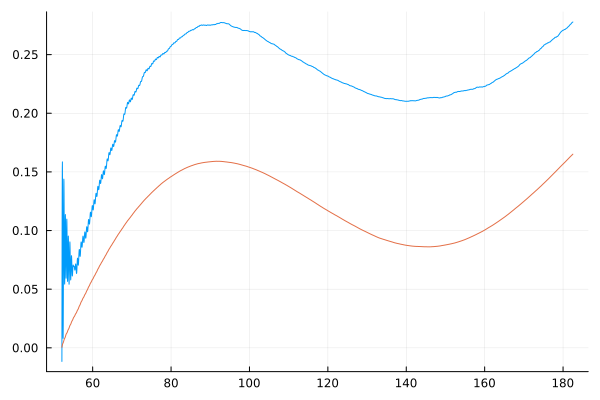

In [1104]:
plot(τ_times, C_integrated)
plot!(τ_times, fτ_ft_integrated)
plot!(legend=nothing)

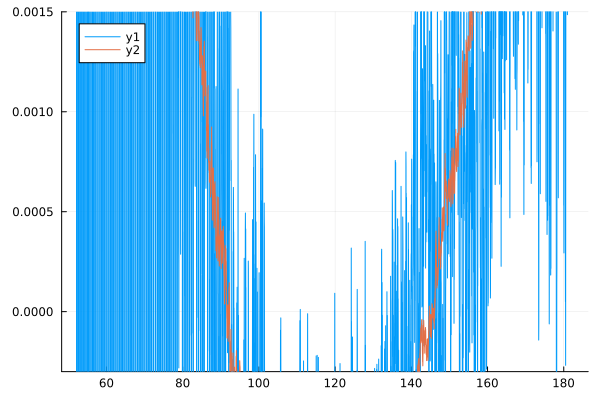

In [1105]:
plot(τ_times, Cs)
plot!(τ_times, fτ_fts)
plot!(ylim=(-0.0003, 0.0015))

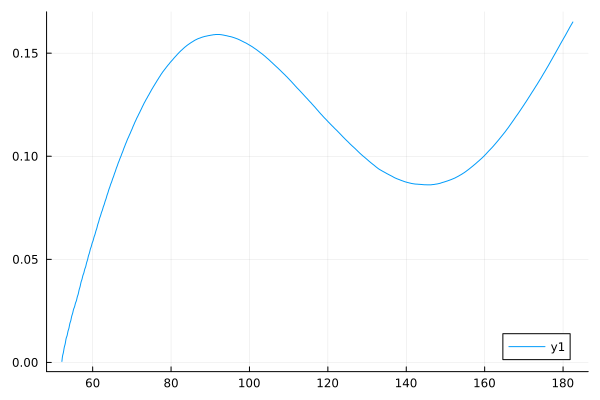

In [1106]:
plot(τ_times, fτ_ft_integrated)

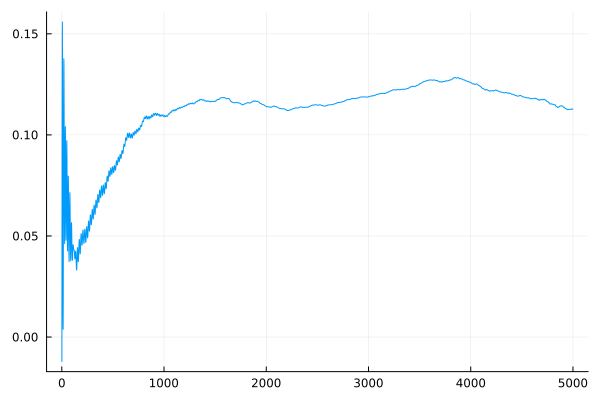

In [1108]:
plot(diffusion, legend=nothing)

In [715]:
using LsqFit

4.759663938848787e-5

2-element Vector{Float64}:
 1.054313087591936
 5.6415200956631186e-5

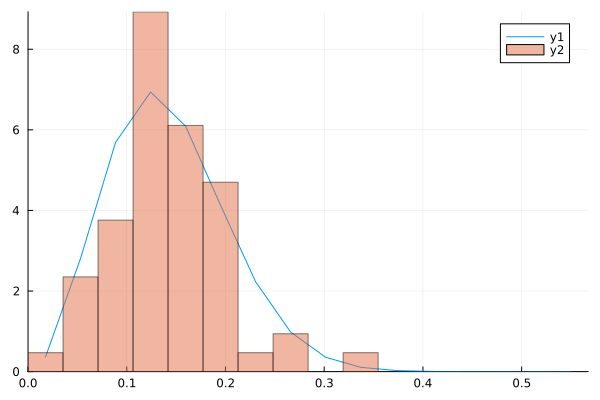

In [716]:
i = 1
vs = [sqrt(vx(sol.u[i])^2 + vy(sol.u[i])^2 + vz(sol.u[i])^2) for sol ∈ ensemble_sol[survived_idxs]]
m * mean(vs)^2 / 3kB |> display

function maxwell_boltzmann(v, p)
    A, temp = p
    return A * ((m/(2π*kB*temp))^(3/2) * 4π) .* v .^2 .* exp.(v .^2 .* (-m / (2*kB*temp)))
end

vs_tofit = vs

hist_data = fit(Histogram, vs_tofit, 0.0:mean(vs_tofit)/4:mean(vs_tofit)*4)
hist_data.isdensity = true
v = collect(hist_data.edges[1])
dv = v[2]-v[1]
v = v[1:end-1] .+ dv/2
fv = hist_data.weights ./ (sum(hist_data.weights) * dv)

histogram(hist_data)

v_fit = curve_fit(maxwell_boltzmann, v, fv, [20, 10e-6])
A, temp = v_fit.param

display(v_fit.param)
plot(v, maxwell_boltzmann(v, v_fit.param))
histogram!(vs_tofit, bins=hist_data.edges, xlim=(0.0, mean(vs)*4), alpha=0.5, normalize=true)

In [285]:
function fit_temperature(vs)

    hist_data = fit(Histogram, vs, 0.0:mean(vs)/5:mean(vs)*2)
    hist_data.isdensity = true
    v = collect(hist_data.edges[1])
    dv = v[2]-v[1]
    v = v[1:end-1] .+ dv/2
    fv = hist_data.weights ./ (sum(hist_data.weights) * dv)
    
    v_fit = curve_fit(maxwell_boltzmann, v, fv, [20, 10e-6])
    A, temp = v_fit.param
    
    return temp
end
; 

In [286]:
vs = [[sqrt(vx(sol.u[i])^2 + vy(sol.u[i])^2 + vz(sol.u[i])^2) for sol ∈ ensemble_sol[survived_idxs]] for i ∈ eachindex(ensemble_sol[1].t)]
;

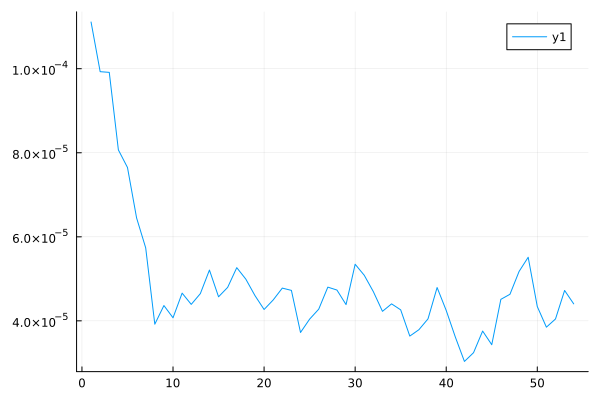

In [287]:
[fit_temperature(vs[i]) for i ∈ eachindex(vs)] |> plot